In [2]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD"
#SIMOUT_DIR = os.path.join(GIMME_DIR, "1d_sims/")
SIMOUT_DIR = GIMME_DIR + "/1d_sims/"
OBSERVED_FILE = os.path.join(GIMME_DIR, "empirical_data/spider.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
## Gather all the simulations from all the running hosts, assumes you're running on cattywampus
## Assumes you have sshpass installed
hosts = {"yowie":"isaac", "yeti":"isaac", "trashquatch":"labuser", "enterprise":"iovercast", "goatzilla":"isaac"}
passwd = {"yowie":"aardvark1", "yeti":"zastards", "trashquatch":"hickerlab", "enterprise":"watwatwat", "goatzilla":"hickerlab"}
simdir = {"yowie":"/Users/isaac/work/",
          "yeti":"/Volumes/WorkDrive/",
          "trashquatch":"/Users/labuser/Documents/isaac/",
          "enterprise":"/home/iovercast/",
          "goatzilla":"/home/isaac/"}

for host in hosts.keys():
    cmd = "sshpass -p \"{}\" scp -r {}@{}:{}gimmeSAD/1d_sims/* /tmp/sims/".format(passwd[host], hosts[host], host, simdir[host])
    print(cmd)
    os.system(cmd)


sshpass -p "aardvark1" scp -r isaac@yowie:/Users/isaac/work/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "watwatwat" scp -r iovercast@enterprise:/home/iovercast/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r labuser@trashquatch:/Users/labuser/Documents/isaac/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r isaac@goatzilla:/home/isaac/gimmeSAD/1d_sims/* /tmp/sims/


## Gather all the simulations into one huge simout file

In [84]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
outfile = open(REF_TABLE, "w")

ONEPER = False
REGULARIZE = False
DROPEQUILIBSIMS = True

files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
numsims = 0
outfile.write(open(files[0]).readlines()[0])
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## DO or don't regularlize the histograms
            if REGULARIZE:
                hist = np.array([int(x) for x in line.split()[7:]])
                if np.sum(hist):
                    tot = np.sum(hist)
                    hist = hist/float(tot)
                tmp = line.split()[:7] + map(str,hist)
                line = " ".join(tmp) + "\n"
                new_lines.append(line)

            ## Do or don't drop all the extra sims at equilibrium
            if line.split()[3] == "1" and DROPEQUILIBSIMS:
                pass
            else:
                new_lines.append(line)
        except:
            pass
    lines = new_lines
    ## Only choose one step per simulation?
    if lines and ONEPER:
        lines = [random.choice(lines)]
    ## Don't write blanks
    if lines:
        numsims += len(lines)
        outfile.write("".join(lines))
        outfile.write("\n")
outfile.close()

print("Processed {} simulations.".format(numsims))

Processed 1135578 simulations.


In [291]:
new_lines[0]
print(numsims)

14640


## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

## Load the data into R

In [85]:
%%R -i OBSERVED_FILE -i REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])
print(OBS)

     K          c  step    X.equil colrate extrate  shannon bin_0 bin_1 bin_2
1 5186 0.01059815 10000 0.02159661  0.0114  0.0035 1.318868    47    10     0
  bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     0     0     0     0     0     0     0
   shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1 3.737537     8    25     7     4     1     3     2     4     1     2


In [262]:
%%R
## Do or don't regularize the observed pi bins
if(TRUE){
    shan = OBS[1]
    tot = sum(OBS[2:11])
    OBS = data.frame(c(shan, OBS[2:11]/tot))
    print(OBS)
}

   shannon     bin_0     bin_1    bin_2      bin_3      bin_4      bin_5
1 3.737537 0.1403509 0.4385965 0.122807 0.07017544 0.01754386 0.05263158
       bin_6      bin_7      bin_8      bin_9
1 0.03508772 0.07017544 0.01754386 0.03508772


## Estimate % equilibrium using shannon index and 1d pi vector


### Rejection

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.2979760
0.01  0.2916369
0.05  0.3408845


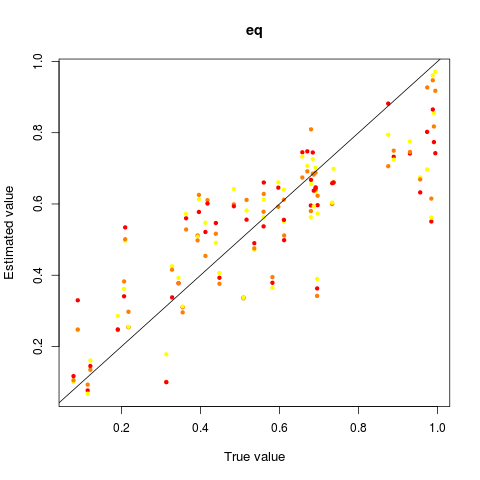

In [36]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(0.005,.05,.01), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

### Loclinear regression

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.3551522
0.01  0.2361144
0.05  0.2130030


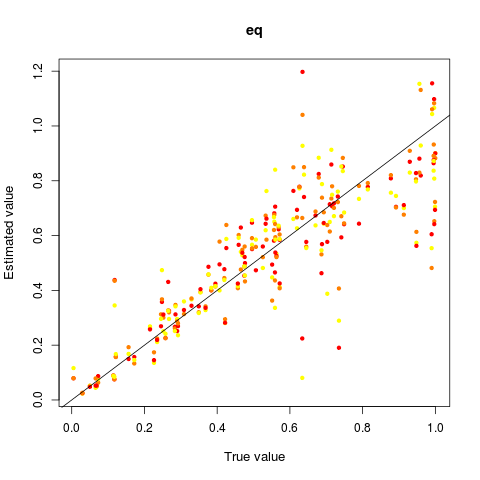

In [37]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Results with pi vectors regularized to sum to 1

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Do the ABC

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7:17], tol = 0.001, method = "rejection")
Data:
 abc.out$unadj.values (1136 posterior samples)

                 eq
Min.:        0.3584
2.5% Perc.:  0.4835
Median:      0.8532
Mean:        0.8147
Mode:        0.9707
97.5% Perc.: 0.9973
Max.:        0.9997
                    eq
Min.:        0.3584392
2.5% Perc.:  0.4835012
Median:      0.8531689
Mean:        0.8147018
Mode:        0.9706608
97.5% Perc.: 0.9972866
Max.:        0.9996886


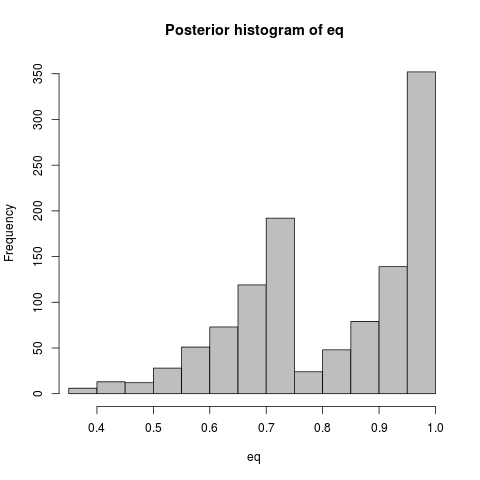

In [90]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.001, method="rejection")
print(summary(res.abc))
hist(res.abc)
#plot(res.abc, param=PRIOR[,"X.equil"])


In [316]:
%%R
res.abc$ss

        shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
  [1,] 3.257509    76    40     6     4     2     3     2     3     0     2
  [2,] 2.955322    42    35     8     4     0     1     4     2     0     2
  [3,] 3.447879    40    29    10     2     0     2     2     4     1     2
  [4,] 3.062392    51    44     5     6     0     2     2     2     0     1
  [5,] 3.251002    60    43     4     6     0     0     1     4     1     1
  [6,] 3.409516    72    55     9     3     1     2     3     2     1     2
  [7,] 2.131541    37    33     4     4     2     2     3     3     1     1
  [8,] 3.445052    36    36    14     5     4     3     1     4     0     1
  [9,] 2.890917    42    38     3     2     1     3     1     2     0     1
 [10,] 2.945705    19    19    12     4     1     1     0     3     0     1
 [11,] 3.072906    59    58    12     5     2     3     1     2     1     2
 [12,] 3.454007    50    37     9     2     2     3     1     3     1     1
 [13,] 2.712

## Estimate colonization rate using shannon index and 1d pi vector

Prediction error based on a cross-validation sample of 50

              eq
0.005 0.10610219
0.01  0.09760246
0.05  0.09416348


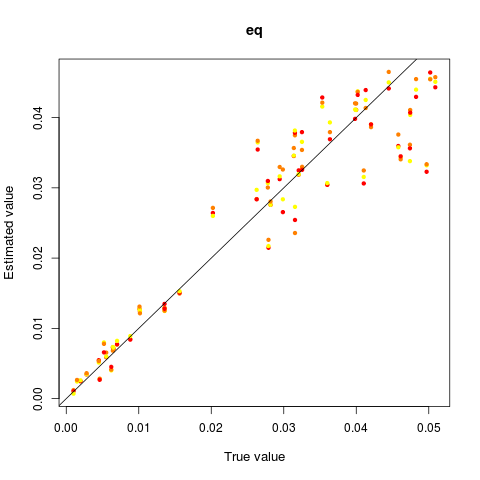

In [47]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=50, tols=c(.005, .01, 0.05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.001, method = "loclinear")
Data:
 abc.out$adj.values (1136 posterior samples)
Weights:
 abc.out$weights

                       colrate
Min.:                  -0.0087
Weighted 2.5 % Perc.:  -0.0030
Weighted Median:        0.0014
Weighted Mean:          0.0016
Weighted Mode:          0.0004
Weighted 97.5 % Perc.:  0.0082
Max.:                   0.0208
                             colrate
Min.:                  -0.0086795499
Weighted 2.5 % Perc.:  -0.0030392260
Weighted Median:        0.0013824708
Weighted Mean:          0.0016322893
Weighted Mode:          0.0004381777
Weighted 97.5 % Perc.:  0.0082199336
Max.:                   0.0208180124


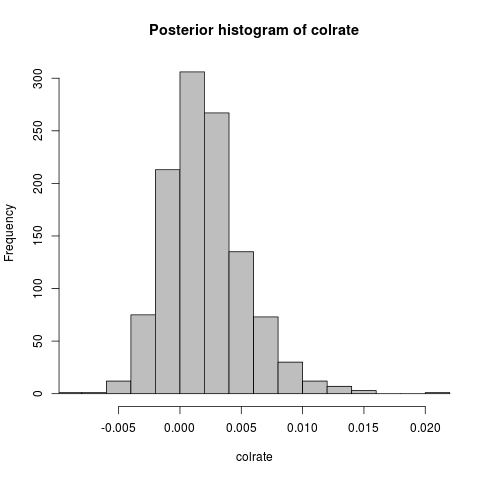

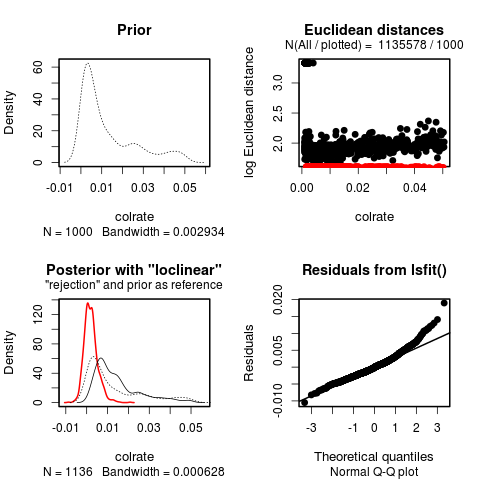

In [92]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"colrate"]), sumstat=PRIOR[,7:17], tol=0.001, method="loclinear")
print(summary(res.abc))
hist(res.abc)
plot(res.abc, param=PRIOR[,"colrate"])

## Estimate shannon using only 1d pi vector

Prediction error based on a cross-validation sample of 100

           shan
0.005 0.1647039
0.01  0.1630450
0.05  0.1549780


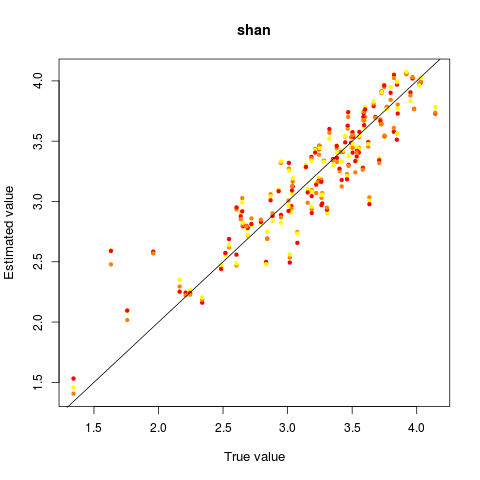

In [49]:
%%R
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17], nval=100, tols=c(.05, .01, .005), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[2:11], param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 0.003, method = "loclinear")
Data:
 abc.out$adj.values (3407 posterior samples)
Weights:
 abc.out$weights

                         shan
Min.:                  2.9153
Weighted 2.5 % Perc.:  3.2474
Weighted Median:       3.5303
Weighted Mean:         3.5224
Weighted Mode:         3.5513
Weighted 97.5 % Perc.: 3.7519
Max.:                  3.9662
                           shan
Min.:                  2.915259
Weighted 2.5 % Perc.:  3.247418
Weighted Median:       3.530264
Weighted Mean:         3.522361
Weighted Mode:         3.551315
Weighted 97.5 % Perc.: 3.751902
Max.:                  3.966173


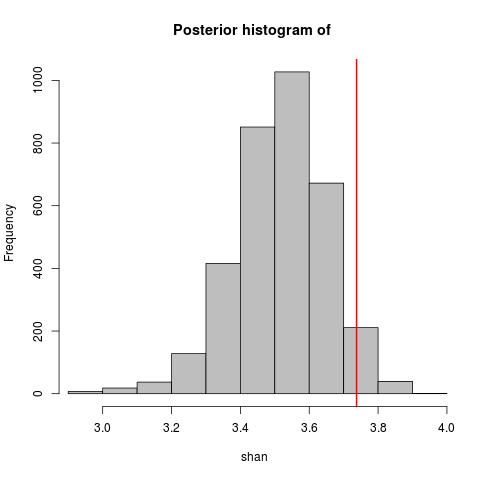

In [158]:
%%R
## w/o 'veil line'
res.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17], tol=0.003, method="loclinear")
## w/ veil line
#res.abc = abc(target=OBS[3:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,9:17], tol=0.05, method="loclinear")
print(summary(res.abc))
hist(res.abc, true=3.737537, cap="", breaks=10)
#plot(res.abc, param=PRIOR[,"shannon"])

## Estimate %equil using only 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.8224691
0.01  0.7990269
0.05  0.8442589


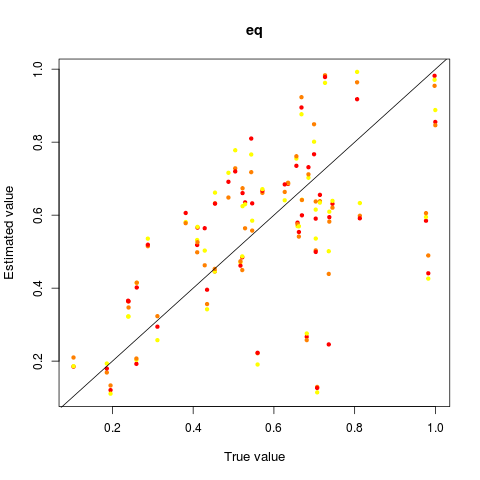

In [50]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,9:17], nval=50, tols=c(.05, .01, .005), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

### Would be good to implement a 'veil line' for undetected species in the empirical dataset

We can fake this by just dropping the singleton bin, here's the code w/o the veil line

`res.abc = abc(target=OBS[2:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.05, method="neuralnet")`

Call: 
abc(target = OBS[3:11], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 9:17], tol = 0.001, method = "loclinear")
Data:
 abc.out$adj.values (1136 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.3778
Weighted 2.5 % Perc.:  0.6417
Weighted Median:       0.9576
Weighted Mean:         0.9653
Weighted Mode:         0.9169
Weighted 97.5 % Perc.: 1.2299
Max.:                  1.3055
                              eq
Min.:                  0.3778037
Weighted 2.5 % Perc.:  0.6417178
Weighted Median:       0.9576258
Weighted Mean:         0.9652751
Weighted Mode:         0.9169272
Weighted 97.5 % Perc.: 1.2298674
Max.:                  1.3055022


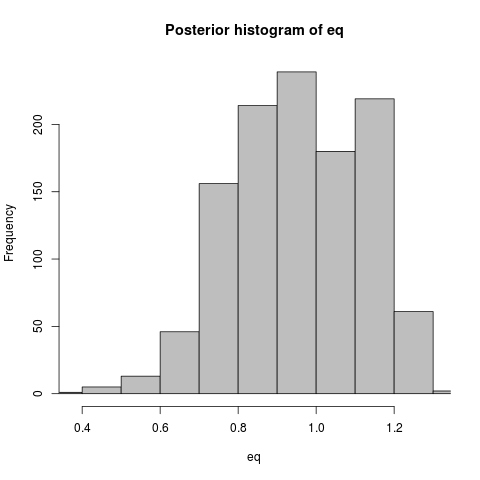

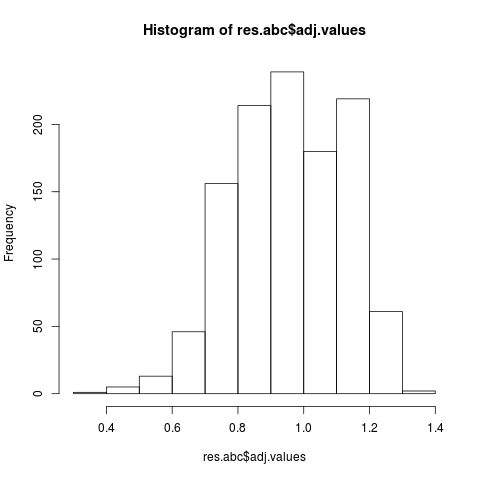

In [117]:
%%R
res.abc = abc(target=OBS[3:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,9:17], tol=0.001, method="loclinear")
print(summary(res.abc))
#print(res.abc$ss)
hist(res.abc)
hist(res.abc$adj.values)
#hist(res.abc$dist)
#plot(res.abc, param=PRIOR[,"X.equil"])


## Prior goodness of fit test for retained simulations


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:29: unexpected symbol
1: withVisible({out=res.abc$ss adj_values
                                ^
[25  7  4  1  3  2  4  1  2]
(9,)
(1136, 9)
[[56 16  3  1  1  0  2  0  0]
 [22  7  5  3  2  1  1  0  2]]
(1137, 9)
[25  7  4  1  3  2  4  1  2]
explained variance ratio (first two components): [ 0.929896    0.05516376]


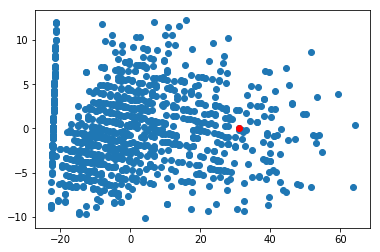

In [122]:
%R -o out out=res.abc$ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(OBSERVED_FILE).readlines()[1].split()[2:]])
print(OBS)
print(OBS.shape)
print(out.shape)
print(out[0:2])

dat = np.vstack([out, OBS])
print(dat.shape)
print(dat[-1])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure()
x, y = zip(*X_r)
plt.scatter(x, y)
plt.scatter(x[-1], y[-1], c="r")

(array([  1.,   0.,   0.,   0.,   1.,   3.,   0.,   1.,   0.,   0.,   2.,
          3.,   3.,   3.,   7.,   5.,   7.,   5.,   9.,  10.,  12.,  23.,
         25.,  19.,  13.,  25.,  38.,  27.,  21.,  38.,  28.,  38.,  47.,
         38.,  41.,  48.,  40.,  26.,  35.,  32.]),
 array([ 0.37780373,  0.39334833,  0.40889293,  0.42443753,  0.43998213,
         0.45552673,  0.47107133,  0.48661593,  0.50216053,  0.51770513,
         0.53324973,  0.54879433,  0.56433893,  0.57988353,  0.59542813,
         0.61097273,  0.62651733,  0.64206193,  0.65760653,  0.67315113,
         0.68869573,  0.70424033,  0.71978493,  0.73532954,  0.75087414,
         0.76641874,  0.78196334,  0.79750794,  0.81305254,  0.82859714,
         0.84414174,  0.85968634,  0.87523094,  0.89077554,  0.90632014,
         0.92186474,  0.93740934,  0.95295394,  0.96849854,  0.98404314,
         0.99958774]),
 <a list of 40 Patch objects>)

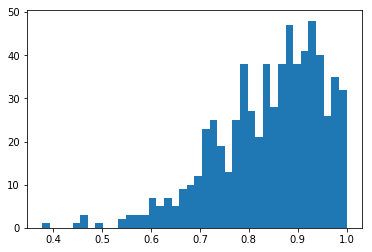

In [131]:
%R -o out out=res.abc$adj.values
adj = np.array([x[0] for x in out])
adj = adj[adj < 1]
plt.hist(adj, bins=40)

(array([ 11.,  11.,  34.,  47.,  81.,  83.,  58.,  59.,  54.,  60.,  70.,
         86.,  78.,  83.,  62.,  54.,  57.,  31.,  48.,  20.,  12.,  12.,
         11.,   5.,   3.,   1.,   2.,   2.,   0.,   1.]),
 array([ 24.74671308,  24.79694794,  24.8471828 ,  24.89741766,
         24.94765252,  24.99788738,  25.04812224,  25.0983571 ,
         25.14859196,  25.19882682,  25.24906168,  25.29929654,
         25.3495314 ,  25.39976626,  25.45000112,  25.50023598,
         25.55047084,  25.6007057 ,  25.65094056,  25.70117542,
         25.75141028,  25.80164514,  25.85188   ,  25.90211486,
         25.95234972,  26.00258458,  26.05281944,  26.1030543 ,
         26.15328916,  26.20352402,  26.25375888]),
 <a list of 30 Patch objects>)

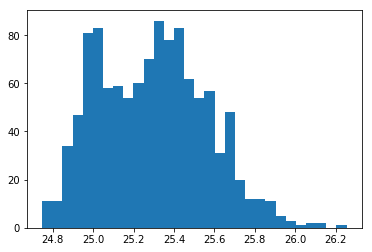

In [132]:
from scipy.spatial.distance import euclidean

dist = []
for vec in out:
    dist.append(euclidean(vec, OBS))
plt.hist(dist, bins=30)

## Estimate %equil using only shannon

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.4442036
0.01  0.4326860
0.05  0.4296489


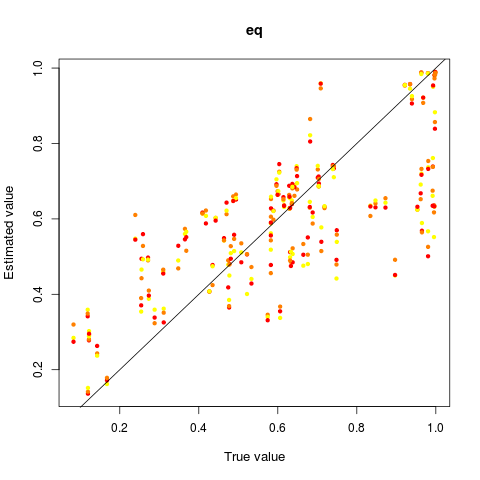

In [69]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7], nval=100, tols=c(.05, .01, .005), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[, 1], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7], tol = 0.001, method = "loclinear")
Data:
 abc.out$adj.values (1136 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.3465
Weighted 2.5 % Perc.:  0.4848
Weighted Median:       0.6882
Weighted Mean:         0.7179
Weighted Mode:         0.6781
Weighted 97.5 % Perc.: 0.9958
Max.:                  1.0147
                              eq
Min.:                  0.3464556
Weighted 2.5 % Perc.:  0.4848100
Weighted Median:       0.6882061
Weighted Mean:         0.7179271
Weighted Mode:         0.6780699
Weighted 97.5 % Perc.: 0.9957573
Max.:                  1.0146709


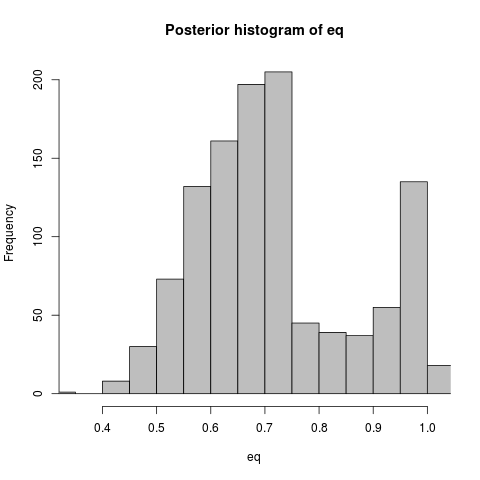

In [133]:
%%R
res.abc = abc(target=OBS[,1], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7], tol=0.001, method="loclinear")
print(summary(res.abc))
hist(res.abc)
#plot(res.abc, param=PRIOR[,"X.equil"])

## Estimate island size using shannon and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.6453266
0.005 0.3867152
0.01  0.3609488
0.05  0.3812574
0.1   0.3750593


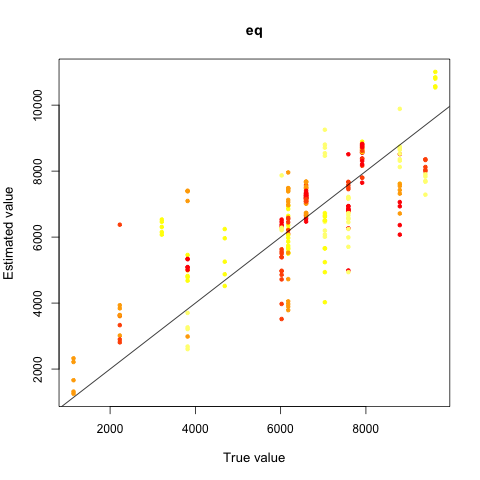

In [74]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"K"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "K"]), sumstat = PRIOR[, 
    7:17], tol = 0.005, method = "loclinear")
Data:
 abc.out$adj.values (5678 posterior samples)
Weights:
 abc.out$weights

                               eq
Min.:                    272.0079
Weighted 2.5 % Perc.:   2061.3803
Weighted Median:        4290.1446
Weighted Mean:          4608.8415
Weighted Mode:          3736.8811
Weighted 97.5 % Perc.:  8706.7512
Max.:                  17434.4858
                               eq
Min.:                    272.0079
Weighted 2.5 % Perc.:   2061.3803
Weighted Median:        4290.1446
Weighted Mean:          4608.8415
Weighted Mode:          3736.8811
Weighted 97.5 % Perc.:  8706.7512
Max.:                  17434.4858


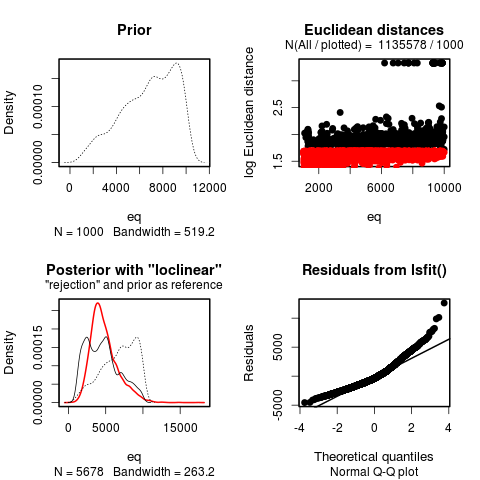

In [134]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"K"]), sumstat=PRIOR[,7:17], tol=0.005, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"K"])

# Co-estimate island size and %equil 

## Estimate island size/%equil using shannon and 1d pi vector

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS[1:11], param = data.frame(c = PRIOR[, "c"], 
    k = PRIOR[, "K"], eq = PRIOR[, "X.equil"]), sumstat = PRIOR[, 
    7:17], tol = 0.005, method = "rejection", hcorr = FALSE)
Data:
 abc.out$unadj.values (5678 posterior samples)

                      c          k         eq
Min.:            0.0010  1047.0000     0.2413
2.5% Perc.:      0.0017  1352.0000     0.4437
Median:          0.0092  4378.0000     0.7436
Mean:            0.0125  4567.2068     0.7766
Mode:            0.0066  5057.6844     0.9751
97.5% Perc.:     0.0409  9387.0000     0.9969
Max.:            0.0499 10000.0000     0.9999
                        c            k           eq
Min.:        1.017463e-03 1.047000e+03 2.413442e-01
2.5% Perc.:  1.693557e-03 1.352000e+03 4.436640e-01
Median:      9.159525e-03 4.378000e+03 7.435892e-01
Mean:        1.246531e-02 4.567207e+03 7.766224e-01
Mode:        6.591364e-03 5.057684e+03 9.751154e-01
97.5% Perc.: 4.094353e-02 9.387000e+03 9.968682e-01
Max.:        4.98

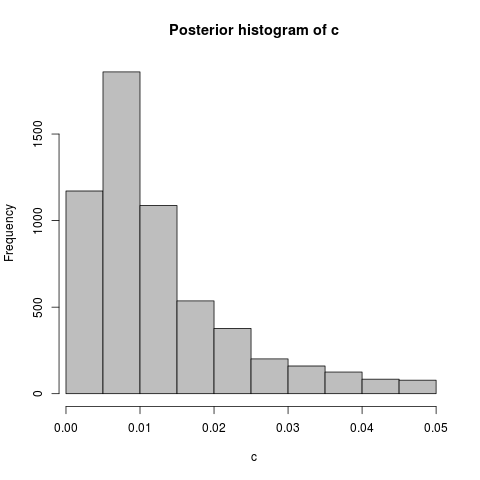

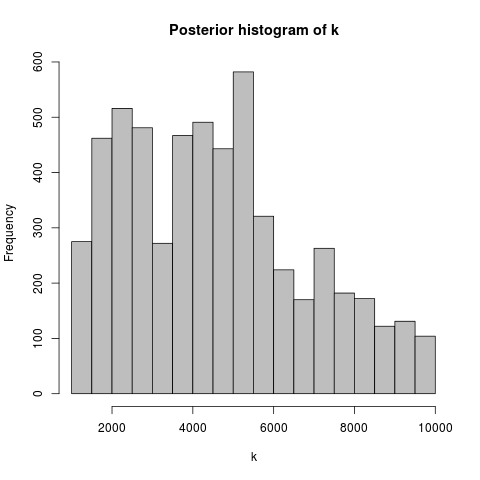

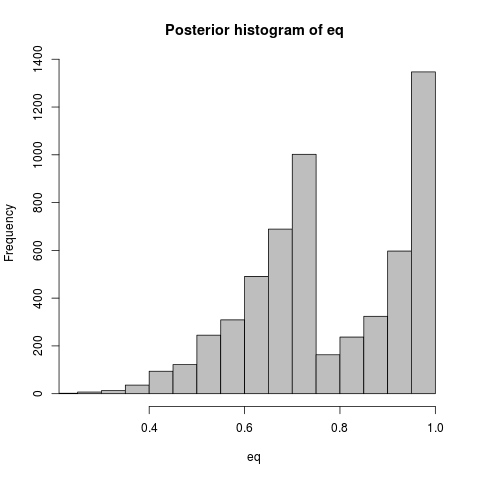

In [152]:
%%R
res.abc = abc(target=OBS[1:11], param=data.frame(c=PRIOR[,"c"], k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], hcorr=FALSE, tol=0.005, method="rejection")
print(summary(res.abc))
hist(res.abc)

#plot(res.abc, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]))

## All crap below here

In [22]:
ss

NameError: name 'ss' is not defined